In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as scp
from scipy import optimize
from scipy import special
from scipy import stats
from itertools import product
import xarray 
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

def sample(func,params,rate):
    searching = True
    time = 0
    while searching:
        nextPassage = func(*params)
        nextRate = np.random.exponential(1/rate)
        if nextRate>nextPassage:
            searching = False
            time += nextPassage
        else:
            time += nextRate
    return time

def pade3_2(x,U0,U1,D1,U2,D2,D3):
    return (U2*x**2+x*U1+U0)/(D3*x**3+D2*x**2+x*D1+1)

def pade3_3(x,U0,D0,U1,D1,U2,D2,U3,D3,D4):
    return (U3*x**3+U2*x**2+x*U1+U0)/(D3*x**3+D2*x**2+x*D1+D0)

def pade3_4(x,A,U1,D1,U2,D2,U3,D3,D4):
    return (U3*x**3+U2*x**2+x*U1+A)/(D4*x**4+D3*x**3+D2*x**2+x*D1+A)

def IGLaplace(rs,L,D,V):
    return np.exp(L/(2*D)*(V-np.sqrt(V**2+4*D*rs)))

def forwardExpansion(x,x0,delta,vals):

    first = (-49/20*vals[0] + 6*vals[1] -15/2*vals[2] + 20/3*vals[3] -15/4*vals[4] + 6/5*vals[5] -1/6*vals[6])/delta
    second = (469/90*vals[0] -223/10*vals[1] +879/20*vals[2] -949/18*vals[3] +41*vals[4] -201/10*vals[5] +1019/180*vals[6]-7/10*vals[7])/(delta**2)
    third = (-801/80*vals[0] +349/6*vals[1] -18353/120*vals[2] +2391/10*vals[3] -1457/6*vals[4] +4891/30*vals[5] -561/8*vals[6]+527/30*vals[7]-469/240*vals[8])/(delta**3)
    fourth = (1069/80*vals[0] -1316/15*vals[1] +15289/60*vals[2] -2144/5*vals[3] +10993/24*vals[4] -4772/15*vals[5] +2803/20*vals[6]-536/15*vals[7]+967/240 *vals[8])/(delta**4)
    
    return vals[0] + first*(x-x0) + second*(x-x0)**2/2 + third*(x-x0)**3/6 + fourth*(x-x0)**4/24

def GammaLaplace(rs,k,theta):
    return (1+rs*theta)**(-k)

def FrechetLaplace(rs,**kwargs):
    return 2*np.sqrt(rs)*scp.special.kn(1,2*np.sqrt(rs))

We will compare different prediction schemes, using exact analytical values of $\tilde{T}(r)$ and
$\langle T_r \rangle = \frac{1-\tilde{T}(r)}{r\tilde{T}(r)}$.

The first chosen distribution is the inverse Gaussian distribution,
$\phi(t) = \frac{L}{\sqrt{4\pi D t^3}}exp\left(-\frac{(L - Vt)^2}{4Dt}\right)$,
with $L =1000000 ,D = 12500000,V = 1$. The mean and CV are $\mu=1ns, \frac{\sigma}{\mu} = 5$. The best improvement factor is ~ 8.5 for $r^*\approx 31ns^{-1}$.

We will compare different schemes for different starting points.

## Pade approximation for $\langle T_r \rangle$:

We will approximate $\langle T_r \rangle$ using $f(r) = \frac{U_3r^3+U_2r^2+U_1r+U_0}{D_3r^3+D_2r^2+D_1r+D_0}$.
We will use 10000 points, from $r=r^*$ to $r_{max} = (C+1)r^*, C=1,10,100,1000$.

For example, here is the case for points between $r^*=0.5ns^{-1}$ and $C=101$ (The dashed lines sign $r=r^*,11r^*,101r^*$):

Text(0, 0.5, '$\\langle T_r \\rangle$ ($ns$)')

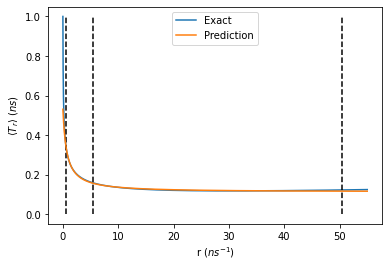

In [2]:
mu = 1000000
CV = 5
D = 0.5*mu*CV**2
m = 2*D/mu
s = mu/m
rs = np.linspace(0,0.000055,10000)
Trs = IGLaplace(rs,mu,D,1)
mus = (1-Trs)/(rs*Trs)
mus[0] = 1e6
plt.plot(rs*1000000,mus/1000000,label="Exact")

rate = 5e-7
for C in [1,11,101]:
    plt.plot([rate*C*1e6,rate*C*1e6],[0,1],c="black",linestyle="dashed")
selrs = np.linspace(rate,rate*101,10000)
selTrs = IGLaplace(selrs,mu,D,1)
selmus = (1-selTrs)/(selrs*selTrs)
fit = scp.optimize.curve_fit(pade3_3, selrs, selmus,bounds=(0,np.inf))
pres = pade3_3(rs,*fit[0])
plt.plot(rs*1000000,pres/1000000,label="Prediction")
plt.legend()
plt.xlabel(r"r ($ns^{-1}$)")
plt.ylabel(r"$\langle T_r \rangle$ ($ns$)")

## Pade approximation for $\tilde{T}(r)$:

We will approximate $\tilde{T}(r)$ using $f(r) = \frac{U_3r^3+U_2r^2+U_1r+A}{D_4r^4+D_3r^3+D_2r^2+D_1r+A}$.
We will use 10000 points, from $r=r^*$ to $r_{max} = (C+1)r^*, C=1,10,100,1000$, and an additional point, $\tilde{T}(0)=1$.

Then, we can approximate $\langle T_0 \rangle$ by $\langle T_0 \rangle = -\frac{\partial \tilde{T}(0)}{\partial r} \approx \frac{D_1-U_1}{A}$

For example, here is the case for points between $r^*=0.5ns^{-1}$ and $C=101$ (The dashed lines sign $r=r^*,11r^*,101r^*$):

Text(0, 0.5, '$\\tilde{T}(r)$')

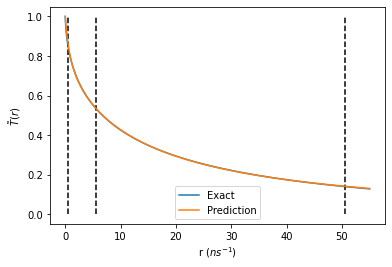

In [3]:
rs = np.linspace(0,0.000055,10000)
Trs = IGLaplace(rs,mu,D,1)
plt.plot(rs*1000000,Trs,label="Exact")
for C in [1,11,101]:
    plt.plot([rate*C*1e6,rate*C*1e6],[0,1],c="black",linestyle="dashed")
fit = scp.optimize.curve_fit(pade3_4, selrs, selTrs,bounds=(0,np.inf))
pres = pade3_4(rs,*fit[0])
plt.plot(rs*1000000,pres,label="Prediction")
plt.legend()
plt.xlabel(r"r ($ns^{-1}$)")
plt.ylabel(r"$\tilde{T}(r)$")

## Taylor expansion

We will use forward finite difference approximations for the first four derivatives of $\langle T_r \rangle$
at $r^*$, and evaluate $\langle T_r \rangle$ using a fourth order Taylor expansion.
We will use $\delta = 0.001r^*,0.01r^*, 0.1r^*,r^*$ for the distance between grid points for the derivatives.

For example, here is the case for $r^*=0.5ns^{-1}$ and $\delta = 0.01r^*$:

([<matplotlib.axis.XTick at 0x7f6f98ab8ca0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

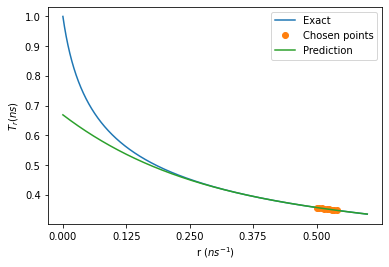

In [4]:
rs = np.linspace(0,0.0000006,10000)
Trs = IGLaplace(rs,mu,D,1)
mus = (1-Trs)/(rs*Trs)
mus[0] = 1e6
plt.plot(rs*1000000,mus/1000000,label="Exact")
selrs = np.linspace(rate,rate+8*rate/100,9)
selTrs = IGLaplace(selrs,mu,D,1)
selmus = (1-selTrs)/(selrs*selTrs)
plt.plot(selrs*1000000,selmus/1000000,"o",label="Chosen points")

pres = forwardExpansion(rs,rate,rate/100,selmus)
plt.plot(rs*1000000,pres/1000000,label="Prediction")
plt.legend()
plt.xlabel(r"r ($ns^{-1}$)")
plt.ylabel(r"$T_r (ns)$")
plt.xticks(np.linspace(0,0.5,5))

We will now plot the predictions of the different methods for several reset rates. The shaded bars represent $\langle T_r \rangle$.

In [5]:
datalist = []
rates = [1e-7,2.5e-7,5e-7,7.5e-7,1e-6,2.5e-6,5e-6,7.5e-6]
for rate in rates:
    ratename = format(rate*1000000,'.2f')
    # method 1+2
    pres2 = []
    for C in [2,11,101,1001]:
        selrs = np.linspace(rate,rate*C,10000)
        selTrs = IGLaplace(selrs,mu,D,1)
        selmus = (1-selTrs)/(selrs*selTrs)
        fit = scp.optimize.curve_fit(pade3_3, selrs, selmus,bounds=(0,np.inf))
        Trs = IGLaplace(rate,mu,D,1)
        mus = (1-Trs)/(rate*Trs)
        prediction = (fit[0][0])/fit[0][1]
        datalist.append(pd.DataFrame(dict(rate = [ratename],method = f"Method 1, C={C-1}",meanTr = mus/1000000, 
                                          improvement = 1e6/mus, prediction = prediction/1000000, error = abs(1e6-prediction)/1e4)))
        
        fit = scp.optimize.curve_fit(pade3_4, selrs, selTrs,bounds=(0,np.inf))
        pres2.append((fit[0][2]-fit[0][1])/fit[0][0])
    for prediction, C in zip(pres2,[2,11,101,1001]):
        datalist.append(pd.DataFrame(dict(rate = [ratename],method = f"Method 2, C={C-1}",meanTr = mus/1000000, 
                          improvement = 1e6/mus, prediction = prediction/1000000, error = abs(1e6-prediction)/1e4)))
    
    for delta in [0.001,0.01,0.1,1]:
        selrs = np.linspace(rate,rate+8*rate*delta,9)
        selTrs = IGLaplace(selrs,mu,D,1)
        selmus = (1-selTrs)/(selrs*selTrs)
        prediction = forwardExpansion(0,rate,rate*delta,selmus)
        datalist.append(pd.DataFrame(dict(rate = [ratename],method = f"Method 3, delta={delta}",meanTr = mus/1000000, 
                          improvement = 1e6/mus, prediction = prediction/1000000, error = abs(1e6-prediction)/1e4)))
    
data = pd.concat(datalist).reset_index()
pd.set_option('display.max_rows', len(data))

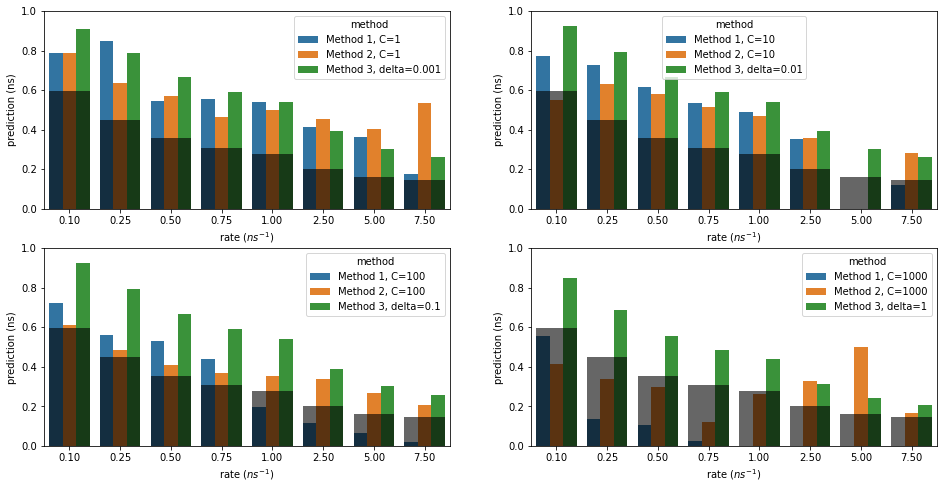

In [6]:
fig, axs = plt.subplots(2,2,figsize=(16,8))
for ax, C, delta in zip(axs.flatten(),[2,11,101,1001],[0.001,0.01,0.1,1]):
    sns.barplot(data=data.query(f"prediction < 2 and method in ['Method 1, C={C-1}','Method 2, C={C-1}','Method 3, delta={delta}']"),
                x="rate",y="prediction",hue="method",ax=ax)
    sns.barplot(data=data.query(f"prediction < 2 and method in ['Method 1, C={C-1}','Method 2, C={C-1}','Method 3, delta={delta}']"),
                x="rate",y="meanTr",ax=ax,color="black",alpha=0.6)
    ax.set_xlabel(r"rate ($ns^{-1}$)")
    ax.set_ylabel("prediction (ns)")
    ax.set_ylim(0,1)

It seems that the third method is the most consistent and precise.
Other methods yield very different results for different C values, while this method yields similar results for different $\delta$ values:

(0.0, 1.0)

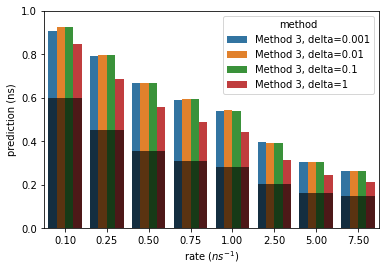

In [7]:
sns.barplot(data=data.query(f"method in ['Method 3, delta=0.001','Method 3, delta=0.01','Method 3, delta=0.1','Method 3, delta=1']"),
                x="rate",y="meanTr",color="black",alpha=0.6,zorder=2)
sns.barplot(data=data.query(f"method in ['Method 3, delta=0.001','Method 3, delta=0.01','Method 3, delta=0.1','Method 3, delta=1']"),
                x="rate",y="prediction",hue="method")
plt.xlabel(r"rate ($ns^{-1}$)")
plt.ylabel("prediction (ns)")
plt.ylim(0,1)

We will now show similar plots for additional distributions: 

1. Gamma distribution, $\phi(t) = \frac{1}{\Gamma(k)\theta^k}t^{k-1}exp\left(-\frac{t}{\theta}\right)$,
using the same mean and CV.

2. Frechet distribution,$\phi(t) = t^{-2}exp\left(-t^{-1}\right)$, with $\langle T_{0.0005} \rangle = 1ns$. We will predict $\langle T_{0.0005} \rangle$
instead of $\langle T_{0} \rangle$ because $\langle T_{0} \rangle$ diverges.

Below are plots of $\langle T_r \rangle$ against r for these distributions.

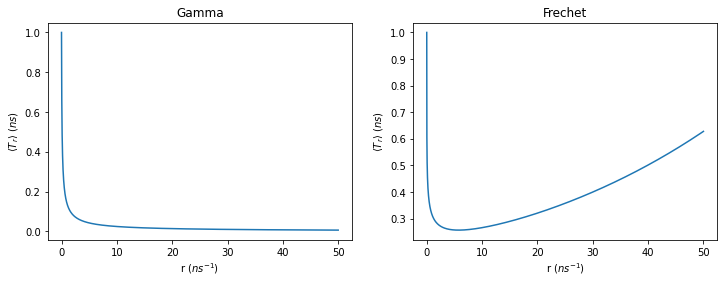

In [8]:
k = 0.04
theta = 2.5e7

# $\langle T_r \rangle$
fig, axs = plt.subplots(1,2,figsize=(12,4))

rs = np.linspace(0,0.00005,10000)
Trs = GammaLaplace(rs,k,theta)
mus = (1-Trs)/(rs*Trs)
mus[0] = 1e6
axs[0].plot(rs*1000000,mus/1000000)
axs[0].set_title("Gamma")

factor = 9.7264
rs = np.linspace(0.0005/factor,50/factor,10000)
Trs = FrechetLaplace(rs)
mus = (1-Trs)/(rs*Trs)/factor
rs = rs*factor
axs[1].plot(rs,mus)
axs[1].set_title("Frechet")

for ax in axs:
    ax.set_xlabel(r"r ($ns^{-1}$)")
    ax.set_ylabel(r"$\langle T_r \rangle$ ($ns$)")

Below are the results for the Gamma distribution.

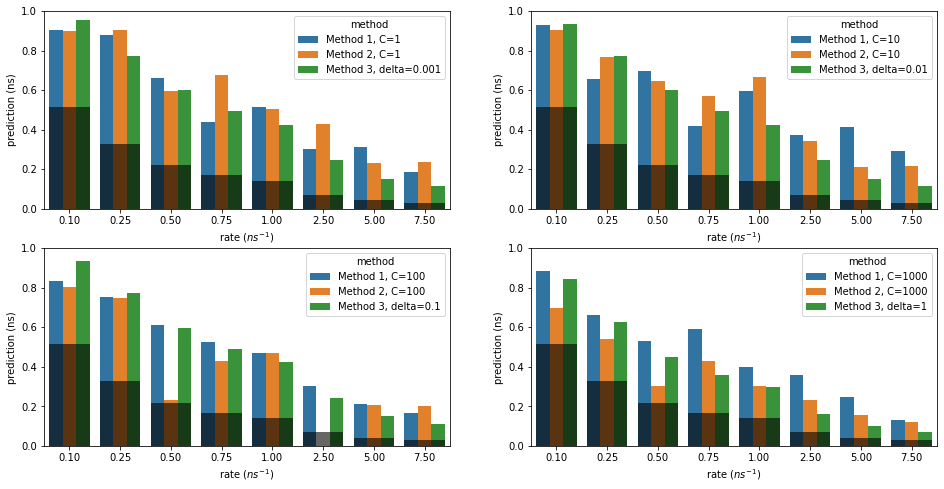

In [9]:
datalist = []
rates = [1e-7,2.5e-7,5e-7,7.5e-7,1e-6,2.5e-6,5e-6,7.5e-6]
for rate in rates:
    ratename = format(rate*1000000,'.2f')
    # method 1+2
    pres2 = []
    for C in [2,11,101,1001]:
        selrs = np.linspace(rate,rate*C,10000)
        selTrs = GammaLaplace(selrs,k,theta)
        selmus = (1-selTrs)/(selrs*selTrs)
        fit = scp.optimize.curve_fit(pade3_3, selrs, selmus,bounds=(0,np.inf))
        Trs = GammaLaplace(rate,k,theta)
        mus = (1-Trs)/(rate*Trs)
        prediction = (fit[0][0])/fit[0][1]
        datalist.append(pd.DataFrame(dict(rate = [ratename],method = f"Method 1, C={C-1}",meanTr = mus/1000000, 
                                          improvement = 1e6/mus, prediction = prediction/1000000, error = abs(1e6-prediction)/1e4)))
        try:
            fit = scp.optimize.curve_fit(pade3_4, selrs, selTrs,bounds=(0,np.inf))
            pres2.append((fit[0][2]-fit[0][1])/fit[0][0])
        except:
            pres2.append(0)
    for prediction, C in zip(pres2,[2,11,101,1001]):
        datalist.append(pd.DataFrame(dict(rate = [ratename],method = f"Method 2, C={C-1}",meanTr = mus/1000000, 
                          improvement = 1e6/mus, prediction = prediction/1000000, error = abs(1e6-prediction)/1e4)))
    
    for delta in [0.001,0.01,0.1,1]:
        selrs = np.linspace(rate,rate+8*rate*delta,9)
        selTrs = GammaLaplace(selrs,k,theta)
        selmus = (1-selTrs)/(selrs*selTrs)
        prediction = forwardExpansion(0,rate,rate*delta,selmus)
        datalist.append(pd.DataFrame(dict(rate = [ratename],method = f"Method 3, delta={delta}",meanTr = mus/1000000, 
                          improvement = 1e6/mus, prediction = prediction/1000000, error = abs(1e6-prediction)/1e4)))
    
data = pd.concat(datalist).reset_index()
fig, axs = plt.subplots(2,2,figsize=(16,8))
for ax, C, delta in zip(axs.flatten(),[2,11,101,1001],[0.001,0.01,0.1,1]):
    sns.barplot(data=data.query(f"prediction < 2 and method in ['Method 1, C={C-1}','Method 2, C={C-1}','Method 3, delta={delta}']"),
                x="rate",y="prediction",hue="method",ax=ax)
    sns.barplot(data=data.query(f"prediction < 2 and method in ['Method 1, C={C-1}','Method 2, C={C-1}','Method 3, delta={delta}']"),
                x="rate",y="meanTr",ax=ax,color="black",alpha=0.6)
    ax.set_xlabel(r"rate ($ns^{-1}$)")
    ax.set_ylabel("prediction (ns)")
    ax.set_ylim(0,1)

For this distribution, the results are not as conclusive. For many cases, methods 1 and 2 performed better than method 3.

Below are the results for the Frechet distribution.

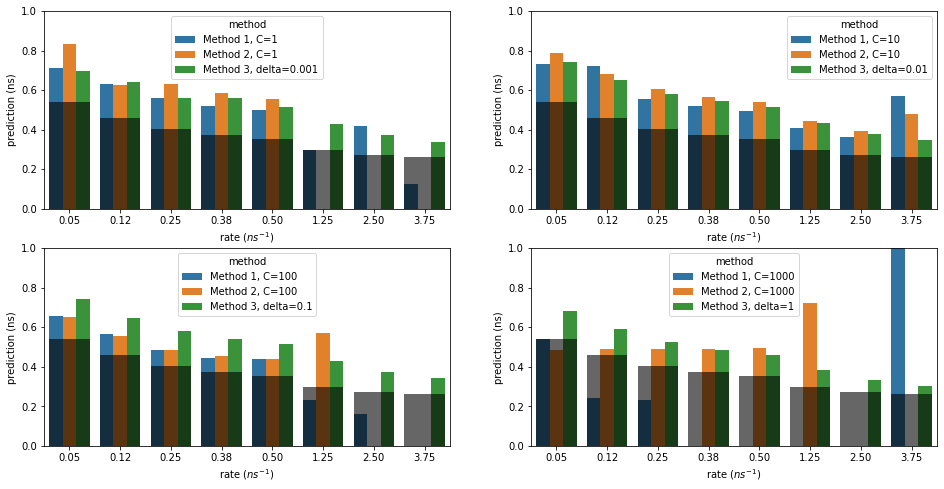

In [10]:
datalist = []
rates = [0.1/factor/2,0.25/factor/2,0.5/factor/2,0.75/factor/2,1/factor/2,2.5/factor/2,5/factor/2,7.5/factor/2]
for rate in rates:
    ratename = format(rate*factor,'.2f')
    # method 1+2
    pres2 = []
    for C in [2,11,101,1001]:
        selrs = np.linspace(rate,rate*C,10000)
        selTrs = FrechetLaplace(selrs)
        selmus = (1-selTrs)/(selrs*selTrs)/factor
        selrs = selrs*factor
        fit = scp.optimize.curve_fit(pade3_3, selrs, selmus,bounds=(0,np.inf))
        Trs = FrechetLaplace(rate)
        mus = (1-Trs)/(rate*Trs)/factor
        prediction = pade3_3(rate,*fit[0])
        datalist.append(pd.DataFrame(dict(rate = [ratename],method = f"Method 1, C={C-1}",meanTr = mus, 
                                          improvement = 1/mus, prediction = prediction, error = abs(1-prediction)*100)))
        
        fit = scp.optimize.curve_fit(pade3_4, selrs-0.0005, selTrs,bounds=(0,np.inf))
        pres2.append((fit[0][2]-fit[0][1])/fit[0][0])
    for prediction, C in zip(pres2,[2,11,101,1001]):
        datalist.append(pd.DataFrame(dict(rate = [ratename],method = f"Method 2, C={C-1}",meanTr = mus, 
                          improvement = 1/mus, prediction = prediction, error = abs(1-prediction)*100)))
    
    for delta in [0.001,0.01,0.1,1]:
        selrs = np.linspace(rate,rate+8*rate*delta,9)
        selTrs = FrechetLaplace(selrs)
        selmus = (1-selTrs)/(selrs*selTrs)/factor
        prediction = forwardExpansion(0,rate,rate*delta,selmus)
        datalist.append(pd.DataFrame(dict(rate = [ratename],method = f"Method 3, delta={delta}",meanTr = mus, 
                          improvement = 1/mus, prediction = prediction, error = abs(1-prediction)*100)))
    
data = pd.concat(datalist).reset_index()
fig, axs = plt.subplots(2,2,figsize=(16,8))
for ax, C, delta in zip(axs.flatten(),[2,11,101,1001],[0.001,0.01,0.1,1]):
    sns.barplot(data=data.query(f"prediction < 2 and method in ['Method 1, C={C-1}','Method 2, C={C-1}','Method 3, delta={delta}']"),
                x="rate",y="prediction",hue="method",ax=ax)
    sns.barplot(data=data.query(f"prediction < 2 and method in ['Method 1, C={C-1}','Method 2, C={C-1}','Method 3, delta={delta}']"),
                x="rate",y="meanTr",ax=ax,color="black",alpha=0.6)
    ax.set_xlabel(r"rate ($ns^{-1}$)")
    ax.set_ylabel("prediction (ns)")
    ax.set_ylim(0,1)

These results don't show significantly better performence for a single method.
Method 3 is more stable regarding to changes in the parameters.